<a href="https://colab.research.google.com/github/TheS1n233/Distributed-Learning-Project5/blob/experiments/NEW%20LocalSGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
!pip install --upgrade torch


# Imports

In [102]:
import torch
import traceback
import argparse
from torch.optim.optimizer import Optimizer, required
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
import json
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR
import matplotlib.pyplot as plt
import copy
import time
from torch.amp import GradScaler, autocast
import os
from google.colab import drive

In [103]:
drive.mount('/content/drive')
if not os.path.exists('/content/drive/MyDrive'):
    raise RuntimeError("Google Drive not mounted correctly!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Costants

In [104]:
NUM_EPOCHS = 15
BATCH_SIZE = 64
NUM_WORKER_LIST = [4]
LOCAL_STEPS = [8]
LR = 0.01
WD = 0.001
MOMENTUM = 0.9
ALPHA = 1.0
BETA = 0.4

## Model

In [105]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)

        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)

        return x

## Function to get train, test and val dataset

In [106]:
def calulcate_mean_std(batch_size=100, verbose=True):
    # Transform only for caluclate meaning of the dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load the CIFAR-100 training dataset
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )


    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False, num_workers=0)

    # Initialize sums for calculating mean and std
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for images, _ in train_loader:
        # Compute mean and std for each channel
        mean += images.mean(dim=[0, 2, 3])
        std += images.std(dim=[0, 2, 3])

    mean /= len(train_loader)
    std /= len(train_loader)

    if verbose:
      print("Mean: ", mean)
      print("Std: ", std)

    return mean, std

In [107]:
def get_dataset(batch_size, verbose=True):

    print("Start loading data with batch_size", batch_size)

    mean, std = calulcate_mean_std()

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    transform_test = transforms.Compose([
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    # Load CIFAR-100 dataset
    start_time = time.time()
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=False,
        download=True,
        transform=transform_test
    )

    if verbose:
      print(f"Dataset loading time: {time.time() - start_time:.2f} seconds")

    # Split training and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    if verbose:
      for i, (inputs, labels) in enumerate(train_loader):
          print(f"Batch {i}: inputs shape: {inputs.shape}, labels shape: {labels.shape}")
          if i == 10:
              break
      print(f"Data loading for 10 batches completed.")
      print(f"Training dataset size: {len(train_dataset)}")
      print(f"Validation dataset size: {len(val_dataset)}")
      print(f"Test dataset size: {len(test_dataset)}")


    print("Data load correctly...")

    return train_loader, val_loader, test_loader

In [108]:

class CheckpointSaver:
    def __init__(self, path, additional_info, k, j, hyperparams, epochs):
        self.timestamp = time.strftime("%Y%m%d-%H%M%S")
        self.path = f"{path}/localSGD_K={k}_J={j}_{self.timestamp}"
        self.additional_info = additional_info
        self.k = k
        self.j = j
        self.hyperparams = hyperparams
        self.epochs = epochs

    def create_files(self):
        os.makedirs(self.path, exist_ok=True)

        self.metrics_files = {
            'global_train_acc': os.path.join(self.path, f'localSGD_train_accuracy_{self.timestamp}_{str(self.additional_info)}.txt'),
            'val_acc': os.path.join(self.path, f'localSGD_val_accuracy_{self.timestamp}_{str(self.additional_info)}.txt'),
            'global_train_loss': os.path.join(self.path, f'localSGD_train_loss_{self.timestamp}_{str(self.additional_info)}.txt'),
            'val_loss': os.path.join(self.path, f'localSGD_val_loss_{self.timestamp}_{str(self.additional_info)}.txt'),
            'summary': os.path.join(self.path, f'localSGD_summary_{self.timestamp}_{str(self.additional_info)}.txt'),
        }

        with open(os.path.join(self.path, f'localSGD_experiment_config_{self.timestamp}_{str(self.additional_info)}.txt'), 'w') as f:
            f.write(f"Experiment Configuration:\n")
            f.write(f"LocalSGD\n")
            f.write(f"K = {self.k}; J = {self.j}\n")
            f.write(f"Hyperparameters: {str(self.hyperparams)}\n")
            f.write(f"Number of epochs: {self.epochs}\n")
            f.write(f"Timestamp: {self.timestamp}\n")

    def save_summary(self, epoch, global_train_accuracy, val_acc, global_train_loss, val_loss, stats):
        try:
            with open(self.metrics_files['summary'], 'a') as f:
                f.write(f"Epoch {epoch}\n")
                f.write(f"Train Loss: {global_train_loss:.4f}, Train Acc: {global_train_accuracy * 100:.2f}%\n")
                f.write(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc * 100:.2f}%\n")
                f.write(f"Stats: \n{stats}")
                f.write("\n\n")
        except Exception as e:
            print(f"Error saving metrics: {e}")

    def save_checkpoint(self, epoch, global_train_accuracy, val_acc, global_train_loss, val_loss):
        try:
            with open(self.metrics_files['global_train_acc'], 'a') as f:
                f.write(f"{epoch},{global_train_accuracy * 100:.2f}%\n")
            with open(self.metrics_files['val_acc'], 'a') as f:
                f.write(f"{epoch},{val_acc * 100:.2f}%\n")
            with open(self.metrics_files['global_train_loss'], 'a') as f:
                f.write(f"{epoch},{global_train_loss:.4f}\n")
            with open(self.metrics_files['val_loss'], 'a') as f:
                f.write(f"{epoch},{val_loss:.4f}\n")
        except Exception as e:
            print(f"Error saving metrics: {e}")

    def end_summary(self, test_acc):
        try:
            with open(self.metrics_files['summary'], 'a') as f:
                f.write(f"Test Accuracy: {test_acc:.2f}%\n\n")
        except Exception as e:
            print(f"Error saving final summary: {e}")

    def save_model_checkpoint(self, model, optimizer, epoch):
        checkpoint_path = os.path.join(self.path, f'checkpoint_epoch_last_3.pth')
        try:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, checkpoint_path)
            print("Checkpoint saved correctly")
        except Exception as e:
            print(f"Error saving model checkpoint: {e}")

    def load_model_checkpoint(self, checkpoint_path):
        try:
            checkpoint = torch.load(checkpoint_path)
            start_epoch = checkpoint['epoch'] + 1
            print(f"Checkpoint loaded successfully. Resuming from epoch {start_epoch}")
            return checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], start_epoch
        except Exception as e:
            print(f"Error loading model checkpoint: {e}")
            return 0

In [109]:
class TimeTracker:
    def __init__(self):
        self.computation_times = []
        self.communication_times = []
        self.epoch_avg_communication_time = []
        self.total_computation = 0.0
        self.total_communication = 0.0
        self.epoch_comp_times = []
        self.epoch_comm_times = []
        self.epoch_ratio_times = []

    def start_computation(self):
        self.comp_start = time.time()

    def end_computation(self):
        comp_time = time.time() - self.comp_start
        self.total_computation += comp_time
        self.computation_times.append(comp_time)
        return comp_time

    def start_communication(self):
        self.comm_start = time.time()

    def end_communication(self):
        comm_time = time.time() - self.comm_start
        self.total_communication += comm_time
        self.communication_times.append(comm_time)
        return comm_time

    def record_epoch(self):
        """Record times for the current epoch"""
        self.epoch_avg_communication_time.append(np.mean(self.communication_times))
        self.epoch_comp_times.append(self.total_computation)
        self.epoch_comm_times.append(self.total_communication)
        self.epoch_ratio_times.append(self.total_computation / (self.total_communication + 1e-10))

    def get_statistics(self):
        """Return summary statistics"""
        stats = {
            'avg_computation_time': np.mean(self.computation_times),
            'avg_communication_time': np.mean(self.communication_times),
            'total_computation_time': self.total_computation,
            'total_communication_time': self.total_communication,
            'computation_to_communication_ratio': np.mean(self.epoch_ratio_times)
        }
        return stats

    def str_statistics(self):
        """Return summary statistics"""
        stats = f"""
            'avg_computation_time': {np.mean(self.computation_times)},
            'avg_communication_time': {np.mean(self.communication_times)},
            'total_computation_time': {self.total_computation},
            'total_communication_time': {self.total_communication},
            'computation_to_communication_ratio': {np.mean(self.epoch_ratio_times)}
        """
        return stats

    def plot_times(self):
        """Plot computation and communication times"""
        plt.figure(figsize=(12, 10))

        # First graph: Plot cumulative times per epoch
        plt.subplot(2, 1, 1)
        epochs = range(1, len(self.epoch_comp_times) + 1)
        plt.plot(epochs, self.epoch_ratio_times, label='ratio_times')


        plt.title('Cumulative Times per Epoch - Ratio')
        plt.xlabel('Epoch')
        plt.ylabel('Total Time (s)')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(epochs, self.epoch_avg_communication_time, label='comm_time')

        plt.title('Cumulative Times per Epoch - Comm time')
        plt.xlabel('Epoch')
        plt.ylabel('Total Time (s)')
        plt.legend()

        plt.tight_layout()
        plt.show()


# LocalSGD

Start loading data with batch_size 64
Files already downloaded and verified
Mean:  tensor([0.5071, 0.4865, 0.4409])
Std:  tensor([0.2667, 0.2558, 0.2754])
Files already downloaded and verified
Files already downloaded and verified
Dataset loading time: 2.69 seconds
Batch 0: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 1: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 2: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 3: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 4: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 5: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 6: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 7: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 8: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torc

<ipython-input-108-8b723ec3e031>:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Statistics 
            'avg_computation_time': 1.1739057210775523,
            'avg_communication_time': 0.005613968922541692,
            'total_computation_time': 15.260774374008179,
            'total_communication_time': 0.07298159599304199,
            'computation_to_communication_ratio': 209.10442071659665
        
Checkpoint saved correctly
Epoch 13 / 15| Train Loss: 3.0845, Train Acc: 23.97%  | Val Loss: 3.0742, Val Acc: 25.45%
Statistics 
            'avg_computation_time': 0.9906459301710129,
            'avg_communication_time': 0.004625461995601654,
            'total_computation_time': 31.700669765472412,
            'total_communication_time': 0.14801478385925293,
            'computation_to_communication_ratio': 211.63837066441783
        
Checkpoint saved correctly
Epoch 14 / 15| Train Loss: 3.0934, Train Acc: 24.22%  | Val Loss: 3.0623, Val Acc: 25.28%
Statistics 
            'avg_computation_time': 0.9545430716346291,
            'avg_communication_time': 0.00434780

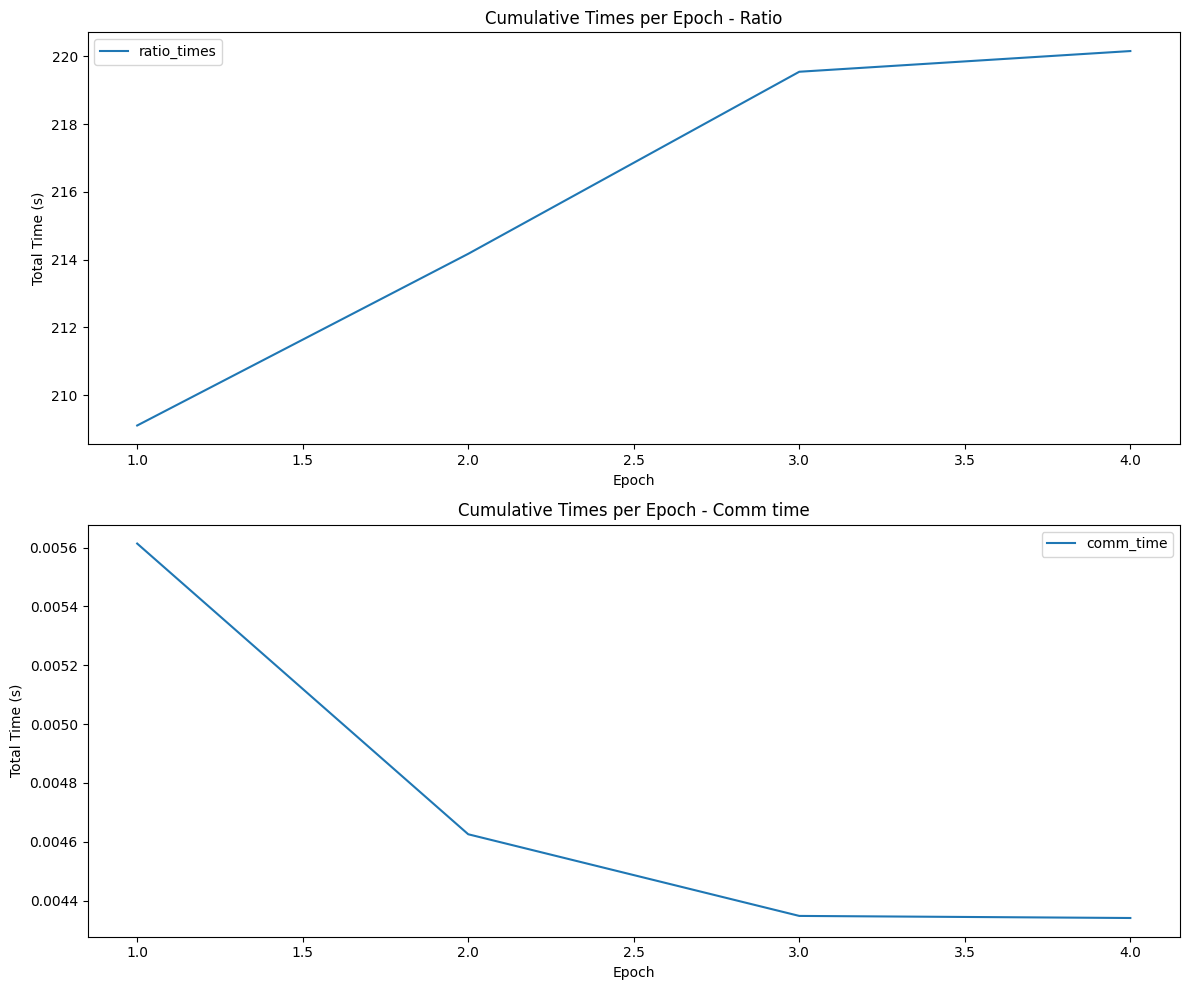

Training results saved to /content/drive/My Drive/Colab Notebooks/Traning_summary//localSGD_K=4_J=8_20250124-223841


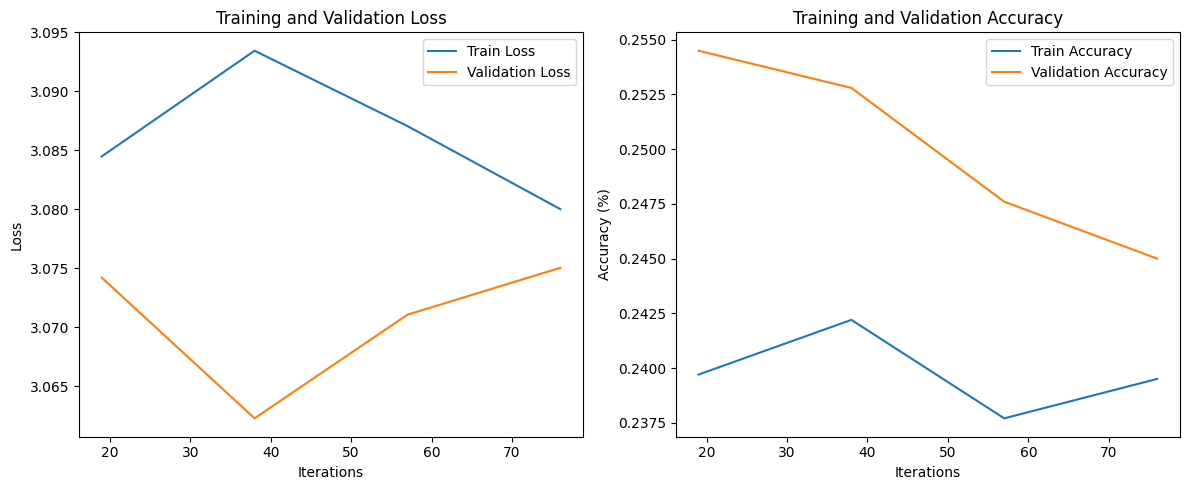

In [110]:
def split_cifar100(dataset, num_workers):
    indices = np.random.permutation(len(dataset))
    splits = np.array_split(indices, num_workers)
    return [torch.utils.data.Subset(dataset, split) for split in splits]


def local_sgd(train_dataset, val_loader, test_loader, device, num_workers, local_steps, num_epochs, batch_size, hyperparams):
    dataset_size = len(train_dataset)
    datasets = split_cifar100(train_dataset, num_workers)

    path = "/content/drive/My Drive/Colab Notebooks/Traning_summary/"
    # Create a CheckpointSaver instance
    cs = CheckpointSaver(
      path=path,
      additional_info=f"K={num_workers}_J={local_steps}",
      k=num_workers,
      j=local_steps,
      hyperparams=hyperparams,
      epochs=num_epochs
    )

    global_model = LeNet5().to(device)

    # Check for existing checkpoint
    checkpoint_path = f"{path}/localSGD_K=4_J=8_20250124-222617/checkpoint_epoch_last_3.pth"
    start_iteration = 0
    if os.path.exists(checkpoint_path):
        model_state_dict, optimizer_state_dict, start_iteration = cs.load_model_checkpoint(checkpoint_path)
        global_model.load_state_dict(model_state_dict)

        local_models = [copy.deepcopy(global_model).to(device) for _ in range(num_workers)]

        local_optimizers = [
            optim.SGD(
                model.parameters(),
                lr=hyperparams['lr'],
                weight_decay=hyperparams['weight_decay'],
                momentum=hyperparams['momentum'],
            ) for model in local_models
        ]

        # Load the state dicts into each optimizer
        for op in local_optimizers:
            op.load_state_dict(optimizer_state_dict)

        print(f"Resumed training from iteration {start_iteration}")
    else:
        print("Starting training from scratch")

        # Initialize local models and optimizers from scratch
        local_models = [copy.deepcopy(global_model).to(device) for _ in range(num_workers)]
        local_optimizers = [
            optim.SGD(
                model.parameters(),
                lr=hyperparams['lr'],
                weight_decay=hyperparams['weight_decay'],
                momentum=hyperparams['momentum'],
            ) for model in local_models
        ]


    workers = [
        torch.utils.data.DataLoader(
            datasets[i],
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True,
        )
        for i in range(num_workers)
    ]

    total_iterations = (num_epochs * (dataset_size // batch_size)) // (num_workers * local_steps)
    iterations_per_epoch = total_iterations // num_epochs




    schedulers = [CosineAnnealingLR(opt, T_max=num_epochs) for opt in local_optimizers]
    criterion = nn.CrossEntropyLoss()
    local_weights = [len(datasets[i].indices) / dataset_size for i in range(num_workers)]

    cs.create_files()


    time_tracker = TimeTracker()
    val_losses, val_accuracies = [], []
    train_losses, train_accuracies = [], []

    worker_iters = [iter(workers[i]) for i in range(num_workers)]

    for iteration in range(start_iteration, total_iterations + 1):

        time_tracker.start_computation()

        # Local training for H steps
        for worker_id in range(num_workers):
            local_models[worker_id].train()
            for _ in range(local_steps):
                try:
                    inputs, labels = next(worker_iters[worker_id])
                except StopIteration:
                    worker_iters[worker_id] = iter(workers[worker_id])
                    inputs, labels = next(worker_iters[worker_id])

                inputs, labels = inputs.to(device), labels.to(device)
                local_optimizers[worker_id].zero_grad()
                outputs = local_models[worker_id](inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                local_optimizers[worker_id].step()

        time_tracker.end_computation()
        time_tracker.start_communication()

        # Model averaging after H steps
        with torch.no_grad():
            global_state_dict = global_model.state_dict()
            for key in global_state_dict.keys():
                global_state_dict[key] = torch.sum(
                    torch.stack([
                        local_weights[i] * local_models[i].state_dict()[key]
                        for i in range(num_workers)
                    ]),
                    dim=0
                )

            global_model.load_state_dict(global_state_dict)
            # Update local models with averaged weights
            for local_model in local_models:
                local_model.load_state_dict(global_state_dict)

        time_tracker.end_communication()


        if (iteration>0 and iteration % iterations_per_epoch == 0) or iteration == total_iterations:
            # Global metrics calculation
            global_model.eval()
            global_train_loss, global_correct, global_total = 0.0, 0, 0
            adjusted_epoch = iteration // iterations_per_epoch
            with torch.no_grad():
                # Train on the global model after local updates
                for inputs, labels in workers[0]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = global_model(inputs)
                    loss = criterion(outputs, labels)
                    global_train_loss += loss.item()
                    _, predicted = outputs.max(1)
                    global_correct += predicted.eq(labels).sum().item()
                    global_total += labels.size(0)

            global_train_loss /= len(workers[0])
            global_train_acc = global_correct / global_total
            train_losses.append(global_train_loss)
            train_accuracies.append(global_train_acc)


            # Validation
            val_acc, val_loss = val_model(global_model, val_loader, criterion, device)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            time_tracker.record_epoch()
            print(f"Statistics", time_tracker.str_statistics())
            cs.save_checkpoint(adjusted_epoch, global_train_acc, val_acc, global_train_loss, val_loss)
            cs.save_summary(adjusted_epoch, global_train_acc, val_acc, global_train_loss, val_loss, time_tracker.str_statistics())
            cs.save_model_checkpoint(global_model, local_optimizers[0], iteration)


            print(f"Epoch {iteration//iterations_per_epoch} / {NUM_EPOCHS}| Train Loss: {global_train_loss:.4f}, Train Acc: {global_train_acc * 100:.2f}%  | Val Loss: {val_loss:.4f}, Val Acc: {val_acc * 100:.2f}%")

            # Step schedulers after each epoch
            for scheduler in schedulers:
                scheduler.step()


    test_acc = test_model(global_model, test_loader, device)
    cs.end_summary(test_acc)
    time_tracker.plot_times()

    return train_losses, val_losses, train_accuracies, val_accuracies, test_acc, total_iterations, iterations_per_epoch, cs.path



def val_model(global_model, val_loader, criterion, device):
    global_model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = global_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    return val_acc, val_loss

def test_model(global_model, test_loader, device):
    global_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = global_model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc * 100:.2f}")


# Visualization function
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, iterations_per_epoch, total_iterations, save_path):
    # Dynamic calculation record points
    recorded_iterations = len(train_losses)
    iterations = range(iterations_per_epoch, iterations_per_epoch * recorded_iterations + 1, iterations_per_epoch)

    # Ensure data length is consistent
    assert len(train_losses) == len(iterations), f"Train losses and iterations mismatch: {len(train_losses)} vs {len(iterations)}"
    assert len(val_losses) == len(iterations), f"Validation losses and iterations mismatch: {len(val_losses)} vs {len(iterations)}"

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(iterations, train_losses, label="Train Loss")
    plt.plot(iterations, val_losses, label="Validation Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(iterations, train_accuracies, label="Train Accuracy")
    plt.plot(iterations, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{save_path}/training_results.png")
    print(f"Training results saved to {save_path}")
    plt.show()

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_epochs = NUM_EPOCHS
    batch_size = BATCH_SIZE
    num_workers_list = NUM_WORKER_LIST
    local_steps_list = LOCAL_STEPS
    hyperparams = {
        'lr': LR,
        'weight_decay': WD,
        'momentum': MOMENTUM,
    }

    train_loader, val_loader, test_loader = get_dataset(batch_size)
    train_dataset = train_loader.dataset

    for num_workers in num_workers_list:
        for local_steps in local_steps_list:
            print(f"Running LocalSGD with {num_workers} workers and {local_steps} local steps")
            train_losses, val_losses, train_accuracies, val_accuracies, test_acc,  total_iterations, iterations_per_epoch, save_path = local_sgd(
                train_dataset=train_dataset,
                val_loader=val_loader,
                test_loader=test_loader,
                device=device,
                num_workers=num_workers,
                local_steps=local_steps,
                num_epochs=num_epochs,
                batch_size=batch_size,
                hyperparams=hyperparams,
            )

            plot_results(train_losses, val_losses, train_accuracies, val_accuracies, iterations_per_epoch, total_iterations, save_path)
